In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import requests
import io
from zipfile import ZipFile
from pathlib import Path

In [2]:
# mpl.style.available
mpl.style.use("seaborn-v0_8-colorblind")

# Missing Values and Data Pipelines [**12P**]

# Dataset

Information on the "Credit Approval" dataset from the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/) dcan be found here: 

* Download URL: https://archive.ics.uci.edu/static/public/27/credit+approval.zip
* DOI: https://doi.org/10.24432/C5FS30
* Dataset creators: J. R. Quinlan
* License: Creative Commons Attribution 4.0 International ([CC BY 4.0](https://creativecommons.org/licenses/by/4.0/legalcode))

### DO NOTE DELETE THIS CELL ###
```

are cells used to inspect you solutions. The output from the Python code is used to grade your submissions. As you might guess from the text, we politely ask you to **not** (!!!) delete **or** copy these cells.

## Download

In [3]:
def download_and_extract(
    url: str, output_path: Path = Path("_data"), verify_ssl: bool = True,
) -> None:
    output_path.mkdir(exist_ok=True, parents=True)

    (
        ZipFile(io.BytesIO(requests.get(url, verify=verify_ssl).content)).extractall(
            path=output_path
        )
    )

In [4]:
DATAURL = "https://archive.ics.uci.edu/static/public/27/credit+approval.zip"
OUTPUT_PATH = Path("_data/credit+approval")

In [5]:
download_and_extract(DATAURL, output_path=OUTPUT_PATH)

# Load 

In [6]:
## From the description of the dataset
# A1:	b, a.
# A2:	continuous.
# A3:	continuous.
# A4:	u, y, l, t.
# A5:	g, p, gg.
# A6:	c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff.
# A7:	v, h, bb, j, n, z, dd, ff, o.possible
# A8:	continuous.
# A9:	t, f.
# A10:	t, f.
# A11:	continuous.
# A12:	t, f.
# A13:	g, p, s.
# A14:	continuous.
# A15:	continuous.
# A16: +,-         (class attribute)


columns_with_missing_values = {
    "A1": 12,
    "A2": 12,
    "A4": 6,
    "A5": 6,
    "A6": 9,
    "A7": 9,
    "A14": 13,
}

## Encode the type of the vars in the column names to be able to better distinguish their type during EDA.
column_dtypes = {
    cname: "float"
    for cname in ("A2-cont", "A3-cont", "A8-cont", "A11-cont", "A14-cont", "A15-cont")
} | {
    cname: "category"
    for cname in (
        "A1-cat",
        "A10-cat",
        "A4-cat",
        "A5-cat",
        "A6-cat",
        "A7-cat",
        "A9-cat",
        "A10-cat",
        "A12-cat",
        "A13-cat",
        "target",
    )
}
# column_dtypes

## Finally, import the data. To be able to convert to the right types, it is helpful to set the `na_values` parameter.
## Otherwise, the automatic type inference might yield a wrong type.
df = pd.read_csv(
    OUTPUT_PATH / "crx.data",
    header=None,
    index_col=False,
    # The missing values are encoded with ?. With the following line we will encode them with NaN
    na_values="?",
    # Set the names of the columns.
    names=sorted(
        (colname for colname in column_dtypes.keys() if colname != "target"),
        key=lambda s: int(s.split("-")[0][1:]),
    )
    + [
        "target",
    ],
    # Set the dtype of the columns.
    dtype=column_dtypes,
)

# [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) [**6P**]

In [7]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import RocCurveDisplay

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
)

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.ensemble import RandomForestClassifier

## Train test split


In [8]:
(
    df_train,
    df_test,
    y_train,
    y_test,
) = train_test_split(
    df.drop(columns="target"),
    df["target"].cat.rename_categories({"+": 1, "-": 0}),  # categorical encoding: 0: gets credit (+), 1: does not get credit (-)
    test_size=0.25,
    random_state=42,
    stratify=df["target"].cat.rename_categories({"+": 1, "-": 0}),
)

(
    df_train.shape,
    df_test.shape,
    y_train.shape,
    y_test.shape,
)

((517, 15), (173, 15), (517,), (173,))

In [9]:
cat_features = df_train.dtypes.loc[lambda s: s == "category"].index.to_list()
cont_features = df_train.dtypes.loc[lambda s: s != "category"].index.to_list()

cat_features, cont_features

(['A1-cat',
  'A4-cat',
  'A5-cat',
  'A6-cat',
  'A7-cat',
  'A9-cat',
  'A10-cat',
  'A12-cat',
  'A13-cat'],
 ['A2-cont', 'A3-cont', 'A8-cont', 'A11-cont', 'A14-cont', 'A15-cont'])

## T: Data preprocessor [**2P**]

> :question: **NOTE** Do you have to explicitly deal with missing values? Consult the [Scikit-Learn User Guide](https://scikit-learn.org/stable/user_guide.html) to answer this question *before* you actually start to construct the data pre-preprocessing pipeline.

Set up a data preprocessor (a column transformer) that can be used in a pipeline together with a [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Make sure to apply *necessary* (this word may have been emphasized deliberately :grin:) "transformations" to the different feature types present in the dataset. The column transformer shall output a Pandas `DataFrame`. 

> :bell: **NOTE** Please use the name `rf_preprocessor` for the `ColumnTransformer` object.

In [10]:
# YOUR CODE HERE
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Preprocessor for categorical features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Preprocessor for continuous features
cont_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

# Column transformer
rf_preprocessor = make_column_transformer(
    (cat_pipeline, cat_features),
    (cont_pipeline, cont_features),
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform="pandas")

In [11]:
# YOUR CODE HERE
rf_pipeline = make_pipeline(
    rf_preprocessor,
    RandomForestClassifier(random_state=42)
)

In [12]:
### DO NOTE DELETE THIS CELL ###

assert(
    isinstance(
        rf_preprocessor
        .fit_transform(df_train), 
        pd.DataFrame,
    )
)

In [13]:
### DO NOTE DELETE THIS CELL ###

(
    rf_preprocessor
    .fit_transform(df_train)
    .head()
)

,A1-cat_a,A1-cat_b,A4-cat_l,A4-cat_u,A4-cat_y,A5-cat_g,A5-cat_gg,A5-cat_p,A6-cat_aa,A6-cat_c,...,A12-cat_t,A13-cat_g,A13-cat_p,A13-cat_s,A2-cont,A3-cont,A8-cont,A11-cont,A14-cont,A15-cont
394,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.399508,0.044643,0.008772,0.000000,0.000000,0.00195
209,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.373848,0.151786,0.228070,0.238806,0.100862,0.01210
449,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.074216,0.250000,0.017544,0.000000,0.000000,0.00000
128,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.295790,0.151786,0.114035,0.029851,0.236207,0.00610
182,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.084511,0.107143,0.005789,0.044776,0.086207,0.00006


## T: Model pipeline [**2P**]

Combine the data preprocessor (`rf_preprocessor`) from the previous task together with a random forest classifier instance in a pipeline.

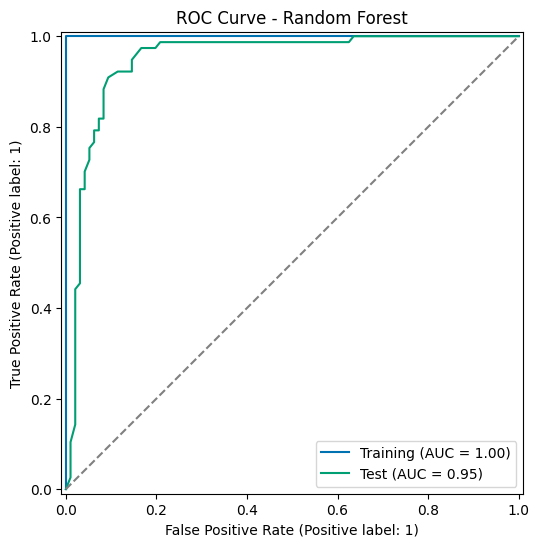

In [14]:
# YOUR CODE HERE
# Fit the model
rf_pipeline.fit(df_train, y_train)

# Create figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot ROC curve for training data
RocCurveDisplay.from_estimator(
    rf_pipeline,
    df_train,
    y_train,
    ax=ax,
    name="Training"
)

# Plot ROC curve for test data
RocCurveDisplay.from_estimator(
    rf_pipeline,
    df_test,
    y_test,
    ax=ax,
    name="Test"
)

# Add diagonal line
ax.plot([0, 1], [0, 1], linestyle="--", color="gray")

# Add title and legend
ax.set_title("ROC Curve - Random Forest")
ax.legend()

plt.show()

## T: Fit the model and evaluate [**2P**]

Fit the model to the training data and visualize the ROC curve for the training as well as the test dataset in a single plot.

In [15]:
# YOUR CODE HERE
from sklearn.preprocessing import FunctionTransformer

# Function to replace NaN with encoded missing value
def replace_nan_with_encoded(X):
    return X.fillna(ENCODED_MISSING_VALUE)

# Preprocessor for categorical features
cat_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=np.nan,
        encoded_missing_value=np.nan
    )),
    ('replace_nan', FunctionTransformer(replace_nan_with_encoded))
])

# Column transformer
hgbc_preprocessor = make_column_transformer(
    (cat_pipeline, cat_features),
    ('passthrough', cont_features),
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform="pandas")

# [`HistGradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier) [**6P**]

Scikit-Learn also offers estimators ("ML models") that can *inherently* deal with missing values. That is, the imputation step in the data processing pipeline can be skipped. Nevertheless, the data often must be prepared in a suitable manner as for the estimator to "know" which values are actually missing. 

You may refer to the following links for a list of estimators that allow NaN values to be present in the input data:

* https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Our choice will be the [`HistGradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier). Its documentation states:

> :speech_bubble: [...] Negative values for categorical features encoded as numeric dtypes are treated as missing values. All categorical values are converted to floating point numbers. [...]

This is the path we will persue: Encode the *categorical* features as numerical values with an [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) and introduce *negative* values for all missing entries.

> **NOTE** You may find [this link](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_categorical.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-categorical-py) very helpful.

Since this classifier can deal with missing values the train test split is different compared to the previous case with the random forest classifier.

In [16]:
(
    df_train,
    df_test,
    y_train,
    y_test,
) = train_test_split(
    df.drop(columns="target"),
    df["target"].cat.rename_categories({"+": 1, "-": 0}),  # categorical encoding: 0: gets credit (+), 1: does not get credit (-)
    test_size=0.25,
    random_state=42,
    stratify=df["target"].cat.rename_categories({"+": 1, "-": 0}),
)

(
    df_train.shape,
    df_test.shape,
    y_train.shape,
    y_test.shape,
)

((517, 15), (173, 15), (517,), (173,))

## T: Data preprocessor [**2P**]

Set up a data preprocessor (column transformer) with the following properties:

* Use an [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder) for the *categorical features*.
    * All non-missing data shall be encoded with a numerical value.
    * All `NaN` values (missing values) shell be left *unchanged*. That is, if we call the `.transform()` or the `.fit_transform()` method of the `OrdinalEncoder` alone (in isolation) the `NaN` values are still present in the output `DataFrame`. 
    * In case the `OrdinalEncoder` encounters unseen values (e.g. when applied to the training dataset) these values should also be replaced with `NaN`s.
* Add a [`FunctionTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html) to replace all `NaN` values output in the previous step with the value assigned to the variable `ENCODED_MISSING_VALUE` below.

> **HINT** What has to be done with the continuous features?

Have a close look at the parameters available for the [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder) to see if there are suitable options.

 
> **HINT** Think about if it is really necessary for the column transformer to alter the names of the feature columns. 

The column transformer shall output a Pandas `DataFrame`.

> **NOTE** Please make sure to name the variable referring to the `ColumnTransformer` the name `hgbc_preprocessor`.

In [17]:
ENCODED_MISSING_VALUE = -1000

In [18]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import FunctionTransformer

In [19]:
# YOUR CODE HERE
# Get indices of categorical features
categorical_features_indices = [
    df_train.columns.get_loc(col) for col in cat_features
]

hgbc_pipeline = make_pipeline(
    hgbc_preprocessor,
    HistGradientBoostingClassifier(
        random_state=42,
        categorical_features=categorical_features_indices
    )
)

In [20]:
### DO NOTE DELETE THIS CELL ###

assert(
    isinstance(
        hgbc_preprocessor.fit_transform(df_train),
        pd.DataFrame
    )
)

In [21]:
### DO NOTE DELETE THIS CELL ###

(
    hgbc_preprocessor
    .fit_transform(df_train)
    .filter(like="cont")
    .head(5)
)

,A2-cont,A3-cont,A8-cont,A11-cont,A14-cont,A15-cont
394,41.17,1.25,0.250,0.0,0.0,195.0
209,39.50,4.25,6.500,16.0,117.0,1210.0
449,20.00,7.00,0.500,0.0,0.0,0.0
128,34.42,4.25,3.250,2.0,274.0,610.0
182,20.67,3.00,0.165,3.0,100.0,6.0


In [22]:
### DO NOTE DELETE THIS CELL ###

(
    hgbc_preprocessor
    .fit_transform(df_train)
    .filter(like="cat")
    # ["A1-cat"].value_counts()
    .loc[:, lambda df_: df_.lt(0).any(axis="rows")]
    .astype(int)
    .eq(ENCODED_MISSING_VALUE)
    .sum(axis="rows")
)

A1-cat    11
A4-cat     5
A5-cat     5
A6-cat     8
A7-cat     8
dtype: int64

In [23]:
### DO NOTE DELETE THIS CELL ###

(
    df_train
    .loc[:, lambda df_: df_.isna().any()]
    .loc[lambda df_: df_.isna().any(axis="columns")]
    .filter(like="cat")
    .isna()
    .sum(axis="rows")
)

A1-cat    11
A4-cat     5
A5-cat     5
A6-cat     8
A7-cat     8
dtype: int64

## T: Model pipeline [**2P**]

Combine the data preprocessor (`hgbc_preprocessor`) from the previous task together with a `HistGradientBoostingClassifier` in a pipeline.

> **NOTE** Make sure the `HistGradientBoostingClassifier` "knows" which variables to treat as categorical.

In [24]:
# YOUR CODE HERE

# Fit the model

# SOLUTION : Convert high-cardinality categorical to numerical
# This should be done BEFORE fitting the model

# Check the cardinality of the problematic feature
print(f"Unique values in A2-cont: {df_train['A2-cont'].nunique()}")
print(f"Sample values: {df_train['A2-cont'].head()}")

# Convert A2-cont to numerical in both training and test sets
df_train['A2-cont'] = pd.to_numeric(df_train['A2-cont'], errors='coerce')
df_test['A2-cont'] = pd.to_numeric(df_test['A2-cont'], errors='coerce')

# Handle any NaN values that might have been created
df_train['A2-cont'].fillna(df_train['A2-cont'].median(), inplace=True)
df_test['A2-cont'].fillna(df_train['A2-cont'].median(), inplace=True)  # Use training median

print(f"After conversion - Unique values: {df_train['A2-cont'].nunique()}")

# Now fit the model
hgbc_pipeline.fit(df_train, y_train)

# Create figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot ROC curve for training data
RocCurveDisplay.from_estimator(
    hgbc_pipeline,
    df_train,
    y_train,
    ax=ax,
    name="Training"
)

# Plot ROC curve for test data
RocCurveDisplay.from_estimator(
    hgbc_pipeline,
    df_test,
    y_test,
    ax=ax,
    name="Test"
)

# Add diagonal line
ax.plot([0, 1], [0, 1], linestyle="--", color="gray")

# Add title and legend
ax.set_title("ROC Curve - HistGradientBoosting")
ax.legend()
plt.show()

Unique values in A2-cont: 297
Sample values: 394    41.17
209    39.50
449    20.00
128    34.42
182    20.67
Name: A2-cont, dtype: float64
After conversion - Unique values: 297


/var/folders/2h/n90r7hkn307dxbjp9vn61nkr0000gn/T/ipykernel_2715/3362779375.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['A2-cont'].fillna(df_train['A2-cont'].median(), inplace=True)
/var/folders/2h/n90r7hkn307dxbjp9vn61nkr0000gn/T/ipykernel_2715/3362779375.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we a

ValueError: Categorical feature 'A2-cont' is expected to have a cardinality <= 255 but actually has a cardinality of 297.

## T: Fit the model and evaluate [**2P**] 

Fit the model to the training data and visualize the ROC curve for the training as well as the test dataset in a single plot.

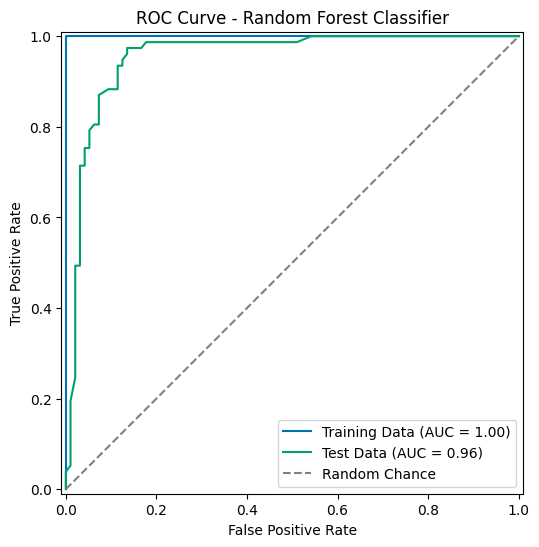

In [ ]:
# YOUR CODE HERE

# Fit the model to the training data
rf_pipeline.fit(df_train, y_train)

# Create a figure for plotting
plt.figure(figsize=(8, 6))

# Plot ROC curve for training data
RocCurveDisplay.from_estimator(
    rf_pipeline,
    df_train,
    y_train,
    name="Training Data",
    ax=plt.gca()
)

# Plot ROC curve for test data
RocCurveDisplay.from_estimator(
    rf_pipeline,
    df_test,
    y_test,
    name="Test Data",
    ax=plt.gca()
)

# Add the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Chance")

# Add titles and labels
plt.title("ROC Curve - Random Forest Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

# Show the plot
plt.show()